# Active Learning using Detectron2 on Comma10k

### - Shreya Nimbhorkar


## Requirements

In [ ]:
!git clone https://github.com/commaai/comma10k

Cloning into 'comma10k'...
remote: Enumerating objects: 68190, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 68190 (delta 84), reused 175 (delta 54), pack-reused 67952
Receiving objects: 100% (68190/68190), 11.35 GiB | 48.65 MiB/s, done.
Resolving deltas: 100% (9082/9082), done.
Checking out files: 100% (24154/24154), done.


In [ ]:
!pip install lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 507 kB 4.7 MB/s 
     |████████████████████████████████| 798 kB 62.5 MB/s 
     |████████████████████████████████| 151 kB 72.6 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 117 kB 69.5 MB/s 
     |████████████████████████████████| 529 kB 61.8 MB/s 
     |████████████████████████████████| 87 kB 8.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144576 sha256=7a3e6e00a62a14b1df6114f9ab2b39fd4c645f1adabb9cc2f31c6e86047bc96d
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=30215c04b5cb93c3aa60955d195021cbbdedacb175902c19551fab9ebb8ff3e4
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e

In [ ]:
# Properly install detectron2. (Please do not install twice in both ways)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xbzd737i
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xbzd737i
     |████████████████████████████████| 50 kB 2.8 MB/s 
     |████████████████████████████████| 1.4 MB 13.8 MB/s 
     |████████████████████████████████| 548 kB 11.4 MB/s 
     |████████████████████████████████| 248 kB 56.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 843 kB 61.6 MB/s 
     |████████████████████████████████| 96 kB 7.0 MB/s 
     |████████████████████████████████| 163 kB 69.6 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5192982 sha256=1593053fa622658c0f777c5b

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob
import tqdm, gc
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# imports for lightly
import lightly
from lightly.active_learning.utils.bounding_box import BoundingBox
from lightly.active_learning.utils.object_detection_output import ObjectDetectionOutput
from lightly.active_learning.scorers import ScorerObjectDetection
from lightly.api.api_workflow_client import ApiWorkflowClient
from lightly.active_learning.agents import ActiveLearningAgent
from lightly.active_learning.config import SelectionConfig
from lightly.openapi_generated.swagger_client import SamplingMethod

In [ ]:
!lightly-magic token="4bbf7d9a8ef692749cc2cf60b3aa26f46f5b08bd25169728" dataset_id="636edd72cea55926187f6d38" \
    input_dir='/content/comma10k/imgs' trainer.max_epochs=3 \
    loader.batch_size=64 loader.num_workers=2


/usr/local/lib/python3.7/dist-packages/hydra/_internal/hydra.py:127: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  configure_logging=with_log_configuration,
########## Starting to train an embedding model.
Downloading: "https://storage.googleapis.com/models_boris/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth" to /root/.cache/torch/hub/checkpoints/whattolabel-resnet18-simclr-d32-w1.0-i-085d0693.pth
100% 42.8M/42.8M [00:02<00:00, 22.0MB/s]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/lightning.py:23: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  "pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7"
/us

In [ ]:
YOUR_TOKEN = "4bbf7d9a8ef692749cc2cf60b3aa26f46f5b08bd25169728"  # your token of the web platform
YOUR_DATASET_ID = "636edd72cea55926187f6d38"  # the id of your dataset on the web platform
DATASET_ROOT = '/content/comma10k/imgs/'

# allow setting of token and dataset_id from environment variables
def try_get_token_and_id_from_env():
    token = os.getenv('TOKEN', YOUR_TOKEN)
    dataset_id = os.getenv('AL_TUTORIAL_DATASET_ID', YOUR_DATASET_ID)
    return token, dataset_id

YOUR_TOKEN, YOUR_DATASET_ID = try_get_token_and_id_from_env()

In [ ]:
# create Lightly API client
api_client = ApiWorkflowClient(dataset_id=YOUR_DATASET_ID, token=YOUR_TOKEN)
al_agent = ActiveLearningAgent(api_client)

In [ ]:
# we can access the images of the dataset we want to use for active learning using
# the `al_agent.query_set` property

# let's print the first 3 entries
print(al_agent.query_set[:3])

['0001_a23b0de0bc12dcba_2018-06-24--00-29-19_17_79.png', '0000_0085e9e41513078a_2018-08-19--13-26-08_11_864.png', '0002_e8e95b54ed6116a6_2018-09-05--22-04-33_2_608.png']


In [ ]:
# The length of the `query_set` should match the number of uploaded
# images
print(len(al_agent.query_set))

1888


## Create our Detectron2 mode

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
###cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
###cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_280758.pkl: 167MB [00:03, 43.8MB/s]                           


In [ ]:
def predict_and_overlay(model, filename):
    # helper method to run the model on an image and overlay the predictions
    im = cv2.imread(filename)
    out = model(im)
    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(out["instances"].to("cpu"))
    plt.figure(figsize=(16,12))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.tight_layout()

In [ ]:
def convert_bbox_detectron2lightly(outputs):
    # convert detectron2 predictions into lightly format
    height, width = outputs['instances'].image_size
    boxes = []

    for (bbox_raw, score, class_idx) in zip(outputs['instances'].pred_boxes.tensor,
                                            outputs['instances'].scores,
                                            outputs['instances'].pred_classes):
        x0, y0, x1, y1 = bbox_raw.cpu().numpy()
        x0 /= width
        y0 /= height
        x1 /= width
        y1 /= height

        boxes.append(BoundingBox(x0, y0, x1, y1))
    output = ObjectDetectionOutput.from_scores(
      boxes, outputs['instances'].scores.cpu().numpy(),
      outputs['instances'].pred_classes.cpu().numpy().tolist())
    return output

## Get Model Predictions

In [ ]:
obj_detection_outputs = []
pbar = tqdm.tqdm(al_agent.query_set, miniters=500, mininterval=60, maxinterval=120)
for fname in pbar:
  fname_full = os.path.join(DATASET_ROOT, fname)
  im = cv2.imread(fname_full)
  out = predictor(im)
  obj_detection_output = convert_bbox_detectron2lightly(out)
  obj_detection_outputs.append(obj_detection_output)

  0%|          | 0/1888 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1888/1888 [04:44<00:00,  6.63it/s]


In [ ]:
scorer = ScorerObjectDetection(obj_detection_outputs)
scores = scorer.calculate_scores()

In [ ]:
max_score = scores['uncertainty_margin'].max()
idx = scores['uncertainty_margin'].argmax()
print(f'Highest uncertainty_margin score found for idx {idx}: {max_score}')

Highest uncertainty_margin score found for idx 1395: 0.9794706106185913


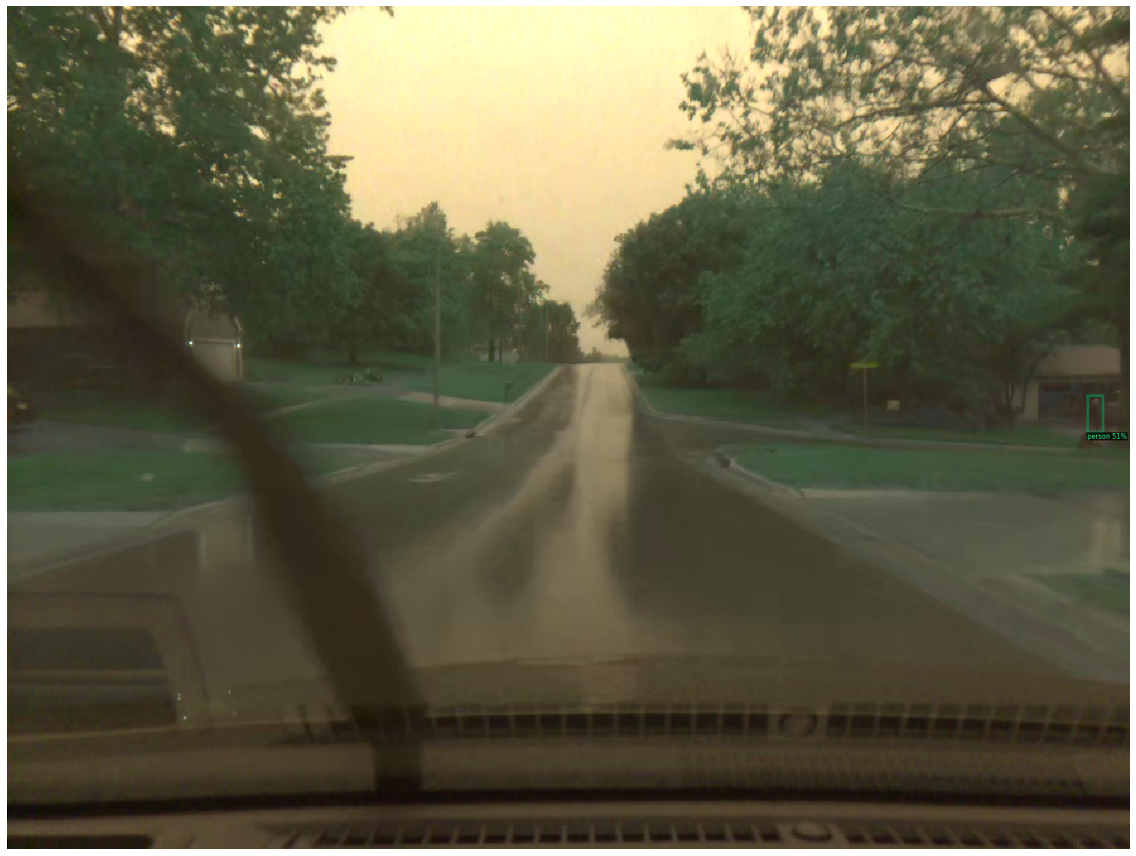

In [ ]:
fname = os.path.join(DATASET_ROOT, al_agent.query_set[idx])
predict_and_overlay(predictor, fname)

In [ ]:
config = SelectionConfig(
  n_samples=100,
  method=SamplingMethod.CORAL,
  name='active-learning-loop-1'
)
al_agent.query(config, scorer)

In [ ]:
print(len(al_agent.added_set))

100


In [ ]:
print(al_agent.added_set[:5])

['0003_97a4ec76e41e8853_2018-09-29--22-46-37_5_585.png', '0009_ef53f1ffea65e93c_2018-07-26--03-48-48_14_191.png', '0010_dad4fa0b6f4978ea_2018-09-07--02-42-25_21_161.png', '0012_76c3bc6da8109da7_2018-09-01--13-03-11_31_1101.png', '0016_5e66baa66592fc5d_2018-05-29--07-52-39_28_98.png']
